In [1]:
import math
import numpy as np
import time
import pandas as pd
import pyopencl as cl
import matplotlib.pyplot as plt
from string import Template
def primes(n):
    x = np.ones((n+1,), dtype=bool)
    x[0] = False
    x[1] = False
    x[4::2] = False
    for i in range(3, int(n**0.5)+1):
        if x[i]:
            x[i*i::2*i] = False
    primes = np.where(x == True)[0]
    return primes

def primes5M8(n,pList): #pList shouldn't include 2
    x = np.ones(((n-5)//8+1,), dtype=bool)
    for i in pList:
        #x[int((i+5)*(i-1)/8)::i] = False
        x[int(i*(i+4)/8)::i] = False
    return x

def squarefree5M8(n,pList): #pList shouldn't include 2
    x = np.ones(((n-5)//8+1,), dtype=bool)
    for i in pList:
        k=i*i
        x[int((5*k-5)/8)::k] = False
    return x

def squarefreeFull(n):
    return getBlock(squarefree5M8(n,primes(int(n**0.5)+1)[1:]))

def primesFull(n):
    return getBlock(primes5M8(n,primes(int(n**0.5)+1)[1:]))

def getBlock(x,all=True,blockSize=0,blockID=0):
    if all:
        return (np.where(x==True)[0])*8+5
    l = len(x)
    start = blockSize * blockID
    end = start + blockSize
    if start >= l:
        return -1
    if end >= l:
        xpart = x[start:]
    else:
        xpart = x[start:end]
    return (np.where(xpart==True)[0]+start)*8+5

In [2]:
def unitsGPU(array,options):
    count = len(array)
    print(count, "values from", array[0], "to", array[-1])
    result = np.zeros(count,dtype=np.int32)
    bstep = np.zeros(count,dtype=np.int32)
    gstep = np.zeros(count,dtype=np.int32)
    sparesize = np.zeros(count,dtype=np.int32)
    
    context = cl.create_some_context()
    queue = cl.CommandQueue(context)
    with open("bsgs5mod8GPU_MHT_NUCOMP.c","r") as file:
        program_src = Template(file.read()).substitute(options)
    program = cl.Program(context, program_src).build()
    
    array_buf = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=array)
    result_buf = cl.Buffer(context, cl.mem_flags.WRITE_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=result)
    bstep_buf = cl.Buffer(context, cl.mem_flags.WRITE_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=bstep)
    gstep_buf = cl.Buffer(context, cl.mem_flags.WRITE_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=gstep)
    sparesize_buf = cl.Buffer(context, cl.mem_flags.WRITE_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=sparesize)
    
    kernel = program.sum_array
    kernel.set_arg(0, array_buf)
    kernel.set_arg(1, result_buf)
    kernel.set_arg(2, bstep_buf)
    kernel.set_arg(3, gstep_buf)
    kernel.set_arg(4, sparesize_buf)
    global_size = (count,)
    
    t1 = time.time()
    cl.enqueue_nd_range_kernel(queue, kernel, global_size, None)
    cl.enqueue_copy(queue, result, result_buf)
    cl.enqueue_copy(queue, bstep, bstep_buf)
    cl.enqueue_copy(queue, gstep, gstep_buf)
    cl.enqueue_copy(queue, sparesize, sparesize_buf)
    queue.finish()
    t2 = time.time()

    print("Finished in", t2-t1, "seconds.")
    
    del array_buf
    del result_buf
    del kernel
    del program
    del queue
    del context
    return result,bstep,gstep,sparesize


In [3]:
maximum = (4*10**10)
t1 = time.time()
A = squarefree5M8(maximum,primes(int(maximum**0.5)+1)[1:])
t2 = time.time()
print("Generated sieve in", t2-t1, "seconds")

Generated sieve in 2560.034159183502 seconds


In [4]:
nBits = 10
options = {"nBits":nBits,"mainDictSize":2**nBits,"spareDictSize":300,"giantStepMax":10000}

In [5]:
t1 = time.time()
counts = np.array([0,0,0])
blockSize=10**8
list0=[]
list1=[]
list2=[]
outputBlockSize = 10**5
for i in range(0,math.ceil(maximum/blockSize)):
    array = getBlock(A,False,blockSize//8,i)
    r,bstep,gstep,sparesize=unitsGPU(array,options)
    if (i==0):
        r[0] = 1
    errorPlace = r<0
    print("Errors at",array[errorPlace])
    print("Error codes are",r[errorPlace])
    print("Results are",r)
    print("Max baby steps needed:",max(bstep))
    print("Max giant steps needed:",max(gstep))
    print("Max number of ideals in the spare list:",max(sparesize))
    c=np.unique(r,return_counts=True)[1][-3:]
    list0 += list(np.bincount(array[r==0]//(outputBlockSize))[-1000:])
    list1 += list(np.bincount(array[r==1]//(outputBlockSize))[-1000:])
    list2 += list(np.bincount(array[r==2]//(outputBlockSize))[-1000:])
    #print("Counts are:",c)
    counts += c
t2 = time.time()
print("Final counts are",counts)
print("Total time:", t2-t1)

10132114 values from 5 to 99999997
Finished in 37.49570083618164 seconds.
Errors at []
Error codes are []
Results are [1 2 1 ... 1 0 1]
Max baby steps needed: 110
Max giant steps needed: 120
Max number of ideals in the spare list: 35
10132139 values from 100000005 to 199999997
Finished in 25.570815801620483 seconds.
Errors at []
Error codes are []
Results are [0 2 0 ... 1 0 2]
Max baby steps needed: 134
Max giant steps needed: 145
Max number of ideals in the spare list: 44
10132098 values from 200000005 to 299999989
Finished in 26.89202380180359 seconds.
Errors at []
Error codes are []
Results are [2 1 1 ... 0 2 0]
Max baby steps needed: 146
Max giant steps needed: 162
Max number of ideals in the spare list: 50
10132129 values from 300000005 to 399999997
Finished in 30.676522970199585 seconds.
Errors at []
Error codes are []
Results are [2 2 0 ... 2 0 0]
Max baby steps needed: 157
Max giant steps needed: 174
Max number of ideals in the spare list: 54
10132116 values from 400000013 to 4

KeyboardInterrupt: 

In [6]:
list0=np.cumsum(list0)
list1=np.cumsum(list1)
list2=np.cumsum(list2)
realPart=list0-1/2*(list1+list2)
imagPart=math.sqrt(3)/2*(list1-list2)
t=list0+list1+list2
s=list1+list2
r=s/list0

df=pd.DataFrame([list0,list1,list2,realPart,imagPart,t,s,r]).transpose()
index = (df.index+1)*outputBlockSize
df.index=index
df.to_csv("testData.csv")

In [42]:
answers = []
t1 = time.time()
for i in array:
    try:
        Ff = reduceQPF(i)
        answers.append(Ff)
    except:
        print(i,"Failed")
t2 = time.time()
print(t2-t1)

0.013852357864379883


In [48]:
array[r!=np.array(answers)]

array([ 829, 1117, 1237, 1589, 1669, 1861, 2149, 2381, 2661, 2773, 3037,
       3061, 3301, 3397, 3421, 3613, 3693, 4189, 4309, 4333, 4349, 4405,
       4461, 4533, 4789, 4909, 4957, 4965, 5021, 5093, 5413, 5461, 5485,
       5581, 5749, 5773, 5981, 6077, 6101, 6181, 6197, 6229, 6269, 6301,
       6349, 6373, 6389, 6421, 6469, 6733, 6781, 7109, 7133, 7149, 7269,
       7341, 7477, 7549, 7669, 7741, 7829, 7901, 7933, 7981, 8013, 8061,
       8157, 8221, 8293, 8301, 8429, 8461, 8629, 8709, 8797, 8813, 9013,
       9109, 9469, 9501, 9557, 9733], dtype=int64)

In [10]:
def getLists(r, part):
    if part == "I":
        return [r==0,r==1,r==2],[0,math.sqrt(3)/2,-math.sqrt(3)/2]
    elif part == "R":
        return [r==0,True],[1,-1/2]
def select(r, part):
    l1, l2 = getLists(r, part)
    return np.select(l1,l2,-999)

In [56]:
randomArray=np.random.randint(0,3,10132114)

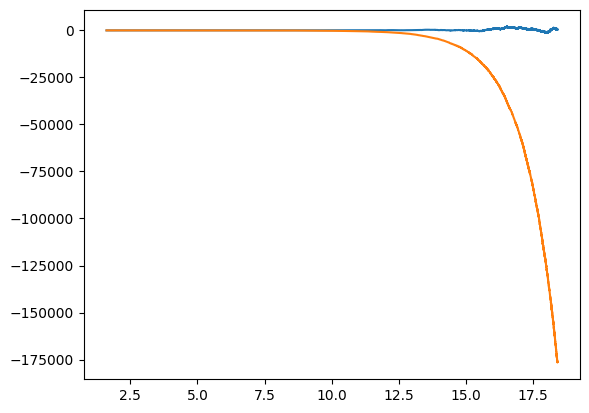

In [100]:
plt.plot(np.log(array[0::100]),np.cumsum(select(randomArray,"R"))[0::100])
plt.plot(np.log(array[0::100]),np.cumsum(select(r,"R"))[0::100])
#plt.plot(array[0::100],bestFitArray[0::100])

In [101]:
bestFitArray=-3/(8*(np.pi**2))*np.power(array,5/6)

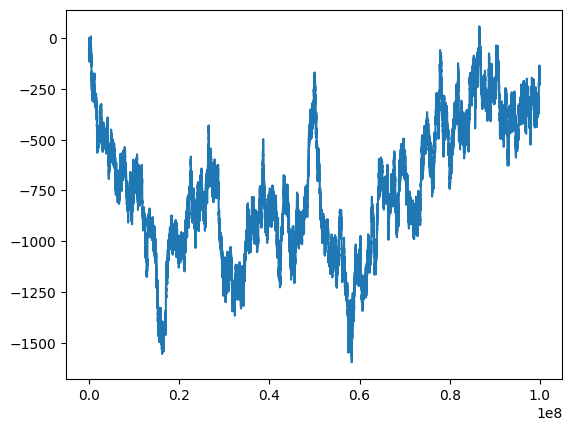

In [104]:
plt.plot(array[0::100],np.cumsum(select(r,"R"))[0::100]-bestFitArray[0::100])

In [78]:
c

array([3259668, 3437623, 3434823], dtype=int64)

In [89]:
def estC(n):
    return n/(np.pi)**2-1/(12*(np.pi)**2)*(4*n-3*(n**(5/6)))

In [99]:
estC(10**9)

68348470.05039348

In [74]:
np.cumsum(select(r,"R"))

array([-5.000000e-01, -1.000000e+00, -1.500000e+00, ..., -1.765555e+05,
       -1.765545e+05, -1.765550e+05])

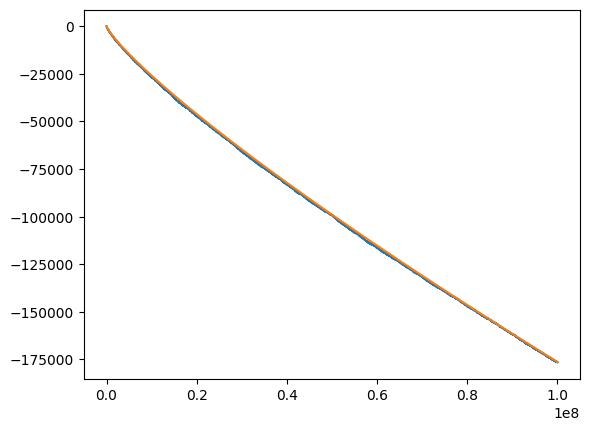

In [77]:
plt.plot(array[0::100],np.cumsum(select(r,"R"))[0::100])
plt.plot(array[0::100],bestFitArray[0::100])

In [23]:
rootArray=array.copy()
rootResult = r.copy()
newArray = np.array([],dtype="int32")
newResult = np.array([],dtype="int32")
newBase = np.array([],dtype="int32")
n = 2
while True:
    lessRoot = rootArray<maximum**(1/n)
    rootResult = rootResult[lessRoot]
    if len(rootResult)==0:
        break
    rootArray = rootArray[lessRoot]
    powerRootArray = rootArray**n
    powerRootResult = (rootResult*n)%3
    newArray = np.concatenate((newArray,powerRootArray))
    newResult = np.concatenate((newResult,powerRootResult))
    newBase = np.concatenate((newBase,rootArray))
    n = n + 1
newResult = np.concatenate((np.log(array)*select(r,"R"),np.log(newBase)*select(newResult,"R")))
newArray = np.concatenate((array,newArray))
argSortArray = np.argsort(newArray)
newArray = newArray[argSortArray]
newResult = newResult[argSortArray]
psiArray = np.cumsum(newResult)

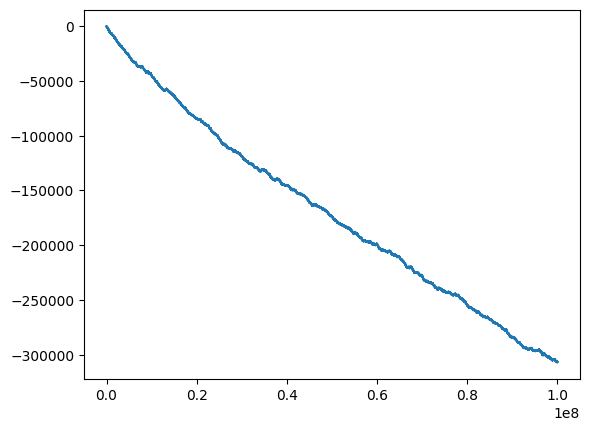

In [24]:
plt.plot(newArray[0::10],psiArray[0::10])
#plt.plot(array[0::1000],bestFitArray[0::1000])

In [ ]:
def sieve(upperLimit, primes):
    r = np.array(list(range(2,upperLimit+1)),dtype=np.int64)
    for p in primes:
        r[2*p-2:upperLimit-1:p]=0
    return r[r!=0]

def GPUsieve(upperLimit, primes, context, queue, program):
    result = np.array(list(range(2,upperLimit+1)),dtype=np.int64)
    count = len(primes)
    array_buf = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=primes)
    result_buf = cl.Buffer(context, cl.mem_flags.WRITE_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=result)
    kernel = program.sum_array
    kernel.set_arg(0, array_buf)
    kernel.set_arg(1, result_buf)
    kernel.set_arg(2, np.int64(upperLimit))
    global_size = (count,)
    cl.enqueue_nd_range_kernel(queue, kernel, global_size, None)
    cl.enqueue_copy(queue, result, result_buf)
    queue.finish()
    
    return result[result!=0]


def fullGPUSieve(upperLimit,context,queue,program):
    if upperLimit < 10:
        return np.array([i for i in range(2,upperLimit+1) if prime(i)],dtype=np.int64)
    else:
        return GPUsieve(upperLimit,fullSieve(math.floor(math.sqrt(upperLimit))),context,queue,program)

def GPUstartArray(n):
    context = cl.create_some_context()
    queue = cl.CommandQueue(context)
    with open("sieve.c","r") as file:
        program_src = file.read()
    program = cl.Program(context, program_src).build()
    return pick5M8(fullGPUSieve(n,context,queue,program))[1:]

def squarefree(n):
    for i in range(2,math.ceil(math.sqrt(n))+1):
        if n%(i**2)==0:
            return False
    return True

def prime(n):
    if n==1:
        return False
    for i in range(2,math.floor(math.sqrt(n))+1):
        if n%i==0:
            return False
    return True

def fullSieve(upperLimit):
    if upperLimit < 10:
        return np.array([i for i in range(2,upperLimit+1) if prime(i)],dtype=np.int64)
    else:
        return sieve(upperLimit,fullSieve(math.floor(math.sqrt(upperLimit))))

def pick5M8(array):
    return array[(array%8)==5]

def startArray(n):
    return pick5M8(fullSieve(n))[1:]


'''start = 13
end = 2**20
t1 = time.time()
array = startArray(end)
print(len(array))
t2 = time.time()
t2 - t1'''